In [1]:
import pandas as pd # pandas for data manipulation
import numpy as np # numpy for sure
import matplotlib.pyplot as plt
# from scipy.sparse import coo_matrix # for constructing sparse matrix
# lightfm 
# from lightfm import LightFM # model
# from lightfm.evaluation import auc_score

# timing
import time

In [2]:
%%time
path = '/Volumes/ADATA HD710/Insight'
aisles = pd.read_csv(path+'/instacart_2017_05_01/aisles.csv')
departments = pd.read_csv(path+'/instacart_2017_05_01/departments.csv')
orders = pd.read_csv(path+'/instacart_2017_05_01/orders.csv')
order_products__prior = pd.read_csv(path+'/instacart_2017_05_01/order_products__prior.csv')
order_products__train = pd.read_csv(path+'/instacart_2017_05_01/order_products__train.csv')
products = pd.read_csv(path+'/instacart_2017_05_01/products.csv')

CPU times: user 11.5 s, sys: 4.52 s, total: 16 s
Wall time: 38.2 s


In [3]:
# visualize headers of all tables
table_names = ['aisles','departments','orders','order_products__prior','order_products__train','products']
for i,df in enumerate([aisles,departments,orders,order_products__prior,order_products__train,products]):
    print(table_names[i])
    print(len(df))
    display(df.head())

aisles
134


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


departments
21


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


orders
3421083


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


order_products__prior
32434489


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


order_products__train
1384617


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


products
49688


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


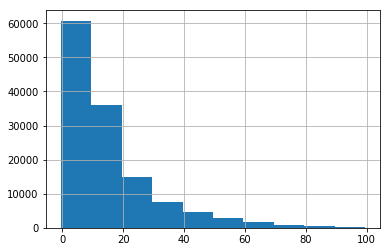

count    131209.000000
mean         16.603937
std          16.661077
min           4.000000
25%           6.000000
50%          10.000000
75%          20.000000
max         100.000000
Name: order_number, dtype: float64

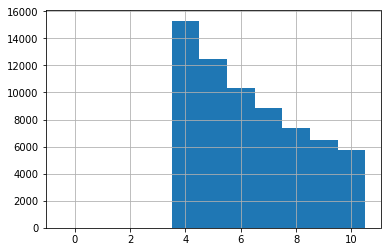

In [74]:
# how many orders per user? What is the distn?
display(orders.loc[orders['eval_set']=='train','order_number'].hist(bins=np.arange(-0.5,100.5,10)))
plt.show()
display(orders.loc[orders['eval_set']=='train','order_number'].hist(bins=np.arange(-0.5,11.5,1)))

display(orders.loc[orders['eval_set']=='train','order_number'].describe())
#mostly less than 20 orders per user, but still something like ~100k users are in that category.
#on low end, at least 4.

In [3]:
%%time

#join previous order_ids by user to each order.
orders['user_id_order'] = orders['user_id']+0.001*orders['order_number']
orders['user_id_prevorder'] = orders['user_id']+0.001*(orders['order_number']-1)
# display(orders.head(13))
orders = orders.merge(orders[['order_id','user_id_order']].set_index('user_id_order'),
                     left_on='user_id_prevorder',right_on='user_id_order',
                     how='left',suffixes=('','_prev'))
# orders.loc[:,'order_id_prev'] = orders['order_id_prev'].astype('int64') #can't do this because some are NaNs
display(orders.head(13))

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_id_order,user_id_prevorder,order_id_prev
0,2539329,1,prior,1,2,8,NaN,1.001,1.000,NaN
1,2398795,1,prior,2,3,7,15.0,1.002,1.001,2539329.0
2,473747,1,prior,3,3,12,21.0,1.003,1.002,2398795.0
3,2254736,1,prior,4,4,7,29.0,1.004,1.003,473747.0
4,431534,1,prior,5,4,15,28.0,1.005,1.004,2254736.0
5,3367565,1,prior,6,2,7,19.0,1.006,1.005,431534.0
6,550135,1,prior,7,1,9,20.0,1.007,1.006,3367565.0
7,3108588,1,prior,8,1,14,14.0,1.008,1.007,550135.0
8,2295261,1,prior,9,1,16,0.0,1.009,1.008,3108588.0
9,2550362,1,prior,10,4,8,30.0,1.010,1.009,2295261.0


CPU times: user 9.48 s, sys: 1.25 s, total: 10.7 s
Wall time: 10.5 s


In [4]:
#add a column for whether an item is organic or not:
def return_organic(prod_name):
    if 'organic' in prod_name.lower():
        return 1
    else:
        return 0
    
products['organic'] = products['product_name'].map(return_organic)

#also merge aisle and department names
products = products.merge(aisles,on='aisle_id')
products = products.merge(departments,on='department_id')
display(products.sample(20))

,product_id,product_name,aisle_id,department_id,organic,aisle,department
2895,8064,Mini Toasts,78,19,0,crackers,snacks
45891,22594,Quattro Formaggi Four Cheeses Pizza,13,20,0,prepared meals,deli
21094,4488,Every Man's One Daily 40 Plus Tablet,47,11,0,vitamins supplements,personal care
41919,14540,Organic Beefsteak Tomato,83,4,1,fresh vegetables,produce
46810,10870,Blue Label Year of the Ram,124,5,0,spirits,alcohol
35103,3142,Organic Short Grain Brown Rice,63,9,1,grains rice dried goods,dry goods pasta
33063,29237,Original Gain Trash,60,17,0,trash bags liners,household
9894,46021,Miya's Guacamole,51,13,0,preserved dips spreads,pantry
11195,45198,Light Miracle Whip Dressing,72,13,0,condiments,pantry
12102,25117,Decaf Ginger Peach Green Tea Bags,94,7,0,tea,beverages


In [5]:
display(aisles.loc[aisles['aisle_id']==94])
display(departments.loc[departments['department_id']==7])
#merge worked correctly!

,aisle_id,aisle
93,94,tea


,department_id,department
6,7,beverages


In [6]:
# how many organic products are in the dataset:
products_org = products.loc[products['organic']==1]
display(products_org)
# ~5000 organic products, out of ~50000

# NOTE product_id column is one off from pandas index. So must not join to other tables by index!

,product_id,product_name,aisle_id,department_id,organic,aisle,department
5,331,Organic Lemon Gingersnap,61,19,1,cookies cakes,snacks
18,1129,Organic Family Recipe Chocolate Chip Cookies,61,19,1,cookies cakes,snacks
34,2023,Organic Stawberry Shortcake Sandwich Cookies,61,19,1,cookies cakes,snacks
73,3769,Organic Mini Peanut Butter Crackers,61,19,1,cookies cakes,snacks
114,6028,Organic Matcha Cooking Grade,61,19,1,cookies cakes,snacks
...,...,...,...,...,...,...,...
49675,47489,Organic Brown Jasmine Rice,68,10,1,bulk grains rice dried goods,bulk
49678,10224,Organic Hunza Golden Raisins,18,10,1,bulk dried fruits vegetables,bulk
49681,14665,Organic White Popcorn,18,10,1,bulk dried fruits vegetables,bulk
49682,19628,Organic Blueberries Package,18,10,1,bulk dried fruits vegetables,bulk


In [5]:
#combine order_products__train and __prior
order_products_combined = order_products__train.append(order_products__prior,sort=False)
display(order_products_combined.sample(10))
print(len(order_products_combined))

,order_id,product_id,add_to_cart_order,reordered
8445372,891467,45066,7,0
30569388,3224390,13780,10,0
16648567,1756088,45570,7,0
4641792,489855,43218,1,0
9106588,961404,48068,7,0
22718852,2396304,45774,3,0
12680512,1338351,980,2,0
2727795,287829,42562,5,1
8197868,865328,28051,10,1
6005424,633901,45495,16,1


33819106


In [7]:
%%time
#join product name and organic status to products in orders
order_products = order_products__train #work on prior only for now (only past orders)
# order_products = order_products__prior #work on train only for now (only most recent orders)
# order_products = order_products_combined #work on train only for now (only most recent orders)
order_products = order_products[['order_id','product_id','add_to_cart_order','reordered']]
order_products = order_products.merge(products,on='product_id')
# order_products.drop('product_id2', axis=1, inplace=True) #remove duplicate column
display(order_products.head(20))

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,organic,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,0,yogurt,dairy eggs
1,816049,49302,7,1,Bulgarian Yogurt,120,16,0,yogurt,dairy eggs
2,1242203,49302,1,1,Bulgarian Yogurt,120,16,0,yogurt,dairy eggs
3,1383349,49302,11,1,Bulgarian Yogurt,120,16,0,yogurt,dairy eggs
4,1787378,49302,8,0,Bulgarian Yogurt,120,16,0,yogurt,dairy eggs
5,2445303,49302,2,1,Bulgarian Yogurt,120,16,0,yogurt,dairy eggs
6,2853065,49302,12,1,Bulgarian Yogurt,120,16,0,yogurt,dairy eggs
7,3231517,49302,6,1,Bulgarian Yogurt,120,16,0,yogurt,dairy eggs
8,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,1,other creams cheeses,dairy eggs
9,68474,11109,8,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,1,other creams cheeses,dairy eggs


CPU times: user 370 ms, sys: 124 ms, total: 494 ms
Wall time: 500 ms


In [46]:
display(order_products.loc[order_products['organic']==1].head(8)) # did join work?

# Double check specific items to make sure join worked.
display(products_org.loc[products_org['product_id']==33120])
display(products_org.loc[products_org['product_id']==11109])
display(products_org.loc[products_org['product_id']==49302]) #not organic so shouldn't up here.

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,organic,aisle,department
8,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,1,other creams cheeses,dairy eggs
9,68474,11109,8,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,1,other creams cheeses,dairy eggs
10,78197,11109,3,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,1,other creams cheeses,dairy eggs
11,120619,11109,1,0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,1,other creams cheeses,dairy eggs
12,128666,11109,12,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,1,other creams cheeses,dairy eggs
13,153973,11109,10,0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,1,other creams cheeses,dairy eggs
14,193761,11109,2,0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,1,other creams cheeses,dairy eggs
15,213799,11109,6,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,1,other creams cheeses,dairy eggs


,product_id,product_name,aisle_id,department_id,organic,aisle,department
29978,33120,Organic Egg Whites,86,16,1,eggs,dairy eggs


,product_id,product_name,aisle_id,department_id,organic,aisle,department
28799,11109,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,1,other creams cheeses,dairy eggs


,product_id,product_name,aisle_id,department_id,organic,aisle,department


In [47]:
display(order_products.loc[order_products['order_id']==98]) # what's going on with order 98? (train df only)
display(order_products.loc[order_products['order_id']==2]) # what's going on with order 98? (prior df only)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,organic,aisle,department
3652,98,13176,4,1,Bag of Organic Bananas,24,4,1,fresh fruits,produce
56472,98,27966,13,1,Organic Raspberries,123,4,1,packaged vegetables fruits,produce
68196,98,8859,1,1,Natural Spring Water,115,7,0,water seltzer sparkling water,beverages
69146,98,19731,2,1,Organic Orange Juice With Calcium & Vitamin D,31,7,1,refrigerated,beverages
69256,98,43654,3,1,Whole Milk Greek Blended Vanilla Bean Yogurt,120,16,0,yogurt,dairy eggs
69426,98,4357,5,1,Organic Chocolate Almondmilk Pudding,71,16,1,refrigerated pudding desserts,dairy eggs
69570,98,37664,6,1,Organic Sliced Provalone Cheese,21,16,1,packaged cheese,dairy eggs
69664,98,34065,7,1,"Tomatoes, Crushed, Organic",81,15,1,canned jarred vegetables,canned goods
69698,98,35951,8,1,Organic Unsweetened Almond Milk,91,16,1,soy lactosefree,dairy eggs
71874,98,43560,9,1,"Crackers, Oyster",78,19,0,crackers,snacks


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,organic,aisle,department


In [18]:
# what is the frequency of each type of organic product (i.e., should we focus on one type?)
display(order_products.loc[order_products['organic']==1,'product_name'].value_counts().head(60))

Bag of Organic Bananas                                            15480
Organic Strawberries                                              10894
Organic Baby Spinach                                               9784
Organic Avocado                                                    7409
Organic Hass Avocado                                               7293
Organic Raspberries                                                5546
Organic Blueberries                                                4966
Organic Whole Milk                                                 4908
Organic Cucumber                                                   4613
Organic Zucchini                                                   4589
Organic Yellow Onion                                               4290
Organic Garlic                                                     4158
Organic Grape Tomatoes                                             3823
Organic Red Onion                                               

In [48]:
# what is the frequency of each type of aisle and department
display(order_products['aisle'].value_counts().head(50))
display(order_products['department'].value_counts().head(50))

#veggies and fruits are the most popular, which is good for the spoilage question.

fresh vegetables                 150609
fresh fruits                     150473
packaged vegetables fruits        78493
yogurt                            55240
packaged cheese                   41699
water seltzer sparkling water     36617
milk                              32644
chips pretzels                    31269
soy lactosefree                   26240
bread                             23635
refrigerated                      23228
ice cream ice                     22676
frozen produce                    22453
eggs                              19875
crackers                          19592
frozen meals                      18221
energy granola bars               17449
lunch meat                        16957
soft drinks                       16279
cereal                            16201
fresh herbs                       16052
fresh dips tapenades              15142
soup broth bouillon               15109
juice nectars                     14350
packaged produce                  13460


produce            409087
dairy eggs         217051
snacks             118862
beverages          114046
frozen             100426
pantry              81242
bakery              48394
canned goods        46799
deli                44291
dry goods pasta     38713
household           35986
meat seafood        30307
breakfast           29500
personal care       21570
babies              14941
international       11902
missing              8251
alcohol              5598
pets                 4497
other                1795
bulk                 1359
Name: department, dtype: int64

In [24]:
order_products.loc[order_products['product_name']=='Bag of Organic Bananas']

,order_id,product_id,add_to_cart_order,reordered,product_name,organic
3651,1,13176,6,0,Bag of Organic Bananas,1
3652,98,13176,4,1,Bag of Organic Bananas,1
3653,170,13176,3,1,Bag of Organic Bananas,1
3654,1077,13176,1,1,Bag of Organic Bananas,1
3655,1325,13176,2,1,Bag of Organic Bananas,1
...,...,...,...,...,...,...
19126,3420498,13176,8,0,Bag of Organic Bananas,1
19127,3420788,13176,1,1,Bag of Organic Bananas,1
19128,3420851,13176,1,1,Bag of Organic Bananas,1
19129,3420857,13176,3,1,Bag of Organic Bananas,1


In [8]:
# sum all the organic products in each order:
orders_organic = order_products[['order_id','organic']].groupby(['order_id']).sum()
orders_organic.sample(5)

,organic
order_id,
496325,3
2858584,3
1104629,2
2302986,9
1040857,1


In [9]:
# join organic status to orders table can use df.join() here because index is order_id above
orders_by_o = orders.join(orders_organic,on='order_id',rsuffix='2')

display(orders_by_o.loc[orders_by_o['eval_set']=='train'].head(20)) # check that join worked
# display(orders_by_o.head(20)) # for when original orders_products table is for all data, not just training data.

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_id_order,user_id_prevorder,order_id_prev,organic
10,1187899,1,train,11,4,8,14.0,1.011,1.010,2550362.0,3.0
25,1492625,2,train,15,1,11,30.0,2.015,2.014,839880.0,6.0
49,2196797,5,train,5,0,11,6.0,5.005,5.004,157374.0,5.0
74,525192,7,train,21,2,11,6.0,7.021,7.020,2452257.0,1.0
78,880375,8,train,4,1,14,10.0,8.004,8.003,2570360.0,9.0
82,1094988,9,train,4,6,10,30.0,9.004,9.003,1830137.0,6.0
88,1822501,10,train,6,0,19,30.0,10.006,10.005,1353310.0,0.0
115,1827621,13,train,13,0,21,8.0,13.013,13.012,1789302.0,1.0
129,2316178,14,train,14,2,19,11.0,14.014,14.013,3394109.0,0.0
200,2180313,17,train,41,3,10,30.0,17.041,17.040,3350883.0,0.0


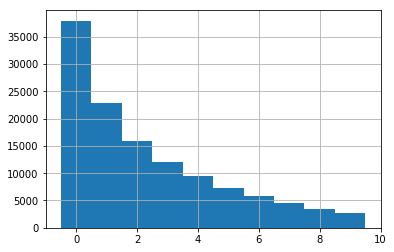

In [29]:
orders_by_o.loc[orders_by_o['eval_set']=='train','organic'].hist(bins=np.arange(-0.5,10.5,1))

In [10]:
# Predicting orders with organic items.
# Order-level. Categorize each order by whether or not it had an organic item or not, and see if we can predict organic carts.
orders_by_o['any_organic'] = orders_by_o['organic']>0
display(orders_by_o.loc[orders_by_o['eval_set']=='train'].sample(20))

display(orders_by_o.loc[orders_by_o['eval_set']=='train','any_organic'].value_counts())
display(orders_by_o.loc[orders_by_o['eval_set']=='train','any_organic'].value_counts(normalize=True))

# Need to join a really long horizontal number of columns based off of every product and whether or not it exists in the order.

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_id_order,user_id_prevorder,order_id_prev,organic,any_organic
311552,3155257,18838,train,14,0,12,7.0,18838.014,18838.013,880418.0,4.0,True
2959306,1553799,178602,train,10,4,9,11.0,178602.010,178602.009,3088908.0,0.0,False
479285,2854330,28889,train,4,6,17,30.0,28889.004,28889.003,820930.0,3.0,True
364539,2675925,22033,train,35,2,14,30.0,22033.035,22033.034,1283303.0,15.0,True
3013673,3219424,181865,train,7,6,12,22.0,181865.007,181865.006,1432183.0,9.0,True
2638734,342648,158867,train,24,6,20,24.0,158867.024,158867.023,2737439.0,1.0,True
1636644,2509821,98252,train,8,6,8,13.0,98252.008,98252.007,445146.0,3.0,True
2631965,1126657,158480,train,8,6,13,0.0,158480.008,158480.007,2832647.0,0.0,False
2926060,762563,176527,train,6,4,10,30.0,176527.006,176527.005,262020.0,2.0,True
2873893,1987368,173389,train,4,1,16,5.0,173389.004,173389.003,1211143.0,7.0,True


True     93287
False    37922
Name: any_organic, dtype: int64

True     0.71098
False    0.28902
Name: any_organic, dtype: float64

In [21]:
# Start with the most recent order by user
# users_order_most_recent = orders_by_o.loc[orders_by_o['eval_set'].map(lambda x: x in ['train','test'])]
users_order_most_recent = orders_by_o.loc[orders_by_o['eval_set'].map(lambda x: x in ['train'])]
display(len(users_order_most_recent)) #206209 users total, 131209 for train
users_order_most_recent['user_id'].value_counts() #only one of every user, as expected.
display(users_order_most_recent.sort_values('user_id').head(10))

131209

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_id_order,user_id_prevorder,order_id_prev,organic,any_organic
10,1187899,1,train,11,4,8,14.0,1.011,1.010,2550362.0,3.0,True
25,1492625,2,train,15,1,11,30.0,2.015,2.014,839880.0,6.0,True
49,2196797,5,train,5,0,11,6.0,5.005,5.004,157374.0,5.0,True
74,525192,7,train,21,2,11,6.0,7.021,7.020,2452257.0,1.0,True
78,880375,8,train,4,1,14,10.0,8.004,8.003,2570360.0,9.0,True
82,1094988,9,train,4,6,10,30.0,9.004,9.003,1830137.0,6.0,True
88,1822501,10,train,6,0,19,30.0,10.006,10.005,1353310.0,0.0,False
115,1827621,13,train,13,0,21,8.0,13.013,13.012,1789302.0,1.0,True
129,2316178,14,train,14,2,19,11.0,14.014,14.013,3394109.0,0.0,False
200,2180313,17,train,41,3,10,30.0,17.041,17.040,3350883.0,0.0,False


In [26]:
%%time
#join product name and organic status to products in orders for orders_products_prev
orders_products_prev = order_products__prior.loc[order_products__prior['order_id'].isin(users_order_most_recent['order_id_prev'].values)]
orders_products_prev = orders_products_prev[['order_id','product_id','add_to_cart_order','reordered']]
orders_products_prev = orders_products_prev.merge(products,on='product_id')
display(orders_products_prev.head(20))

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,organic,aisle,department
0,25,9755,1,1,Original Popcorn,23,19,0,popcorn jerky,snacks
1,12917,9755,24,1,Original Popcorn,23,19,0,popcorn jerky,snacks
2,37056,9755,13,0,Original Popcorn,23,19,0,popcorn jerky,snacks
3,65812,9755,9,0,Original Popcorn,23,19,0,popcorn jerky,snacks
4,66323,9755,11,0,Original Popcorn,23,19,0,popcorn jerky,snacks
5,89933,9755,1,1,Original Popcorn,23,19,0,popcorn jerky,snacks
6,92311,9755,41,0,Original Popcorn,23,19,0,popcorn jerky,snacks
7,104308,9755,1,1,Original Popcorn,23,19,0,popcorn jerky,snacks
8,108109,9755,6,1,Original Popcorn,23,19,0,popcorn jerky,snacks
9,134992,9755,7,1,Original Popcorn,23,19,0,popcorn jerky,snacks


CPU times: user 2.71 s, sys: 1.14 s, total: 3.85 s
Wall time: 3.91 s


In [28]:
%%time

# Create a really wide table with a lot ofcolumns based off of every product and whether or not it exists in the order.
# order_test = order_products
# order_test['exists'] = 1
# display(order_test.head(5))

# order_test_fat = order_test.pivot(index='order_id',columns='product_id',values='exists')
# display(order_test_fat)

# the above was a bad idea. Brian suggested to group first by aisle or department, maybe # of products in that aisle/department.
# 134 aisles and 21 departments

sample_order_id = 25 # check this order

# only get aisles and departments for orders immediately prior to "train" orders
order_by_aisle = pd.DataFrame(orders_products_prev.groupby(['order_id'])['aisle'].value_counts())
display(order_by_aisle.head(10))

order_by_aisle_wide = order_by_aisle.unstack(fill_value=0)
display(order_by_aisle_wide)
#check that the unstacking worked:
display(order_by_aisle_wide.loc[sample_order_id].sort_values(ascending=False).head(10)) #order_id=1

#repeat with 21 departments
order_by_dept = pd.DataFrame(orders_products_prev.groupby(['order_id'])['department'].value_counts())
display(order_by_dept.head(10))

order_by_dept = order_by_dept.unstack(fill_value=0)
display(order_by_dept)
#check that the unstacking worked:
display(order_by_dept.loc[sample_order_id].sort_values(ascending=False).head(10)) #order_id=1


aisle
order_id aisle                         
25       packaged cheese              3
         popcorn jerky                2
         dog food care                1
         eggs                         1
         frozen appetizers sides      1
         frozen breakfast             1
         frozen meals                 1
         frozen pizza                 1
         frozen produce               1
         hot dogs bacon sausage       1

aisle                               \
aisle    air fresheners candles asian foods baby accessories   
order_id                                                       
25                            0           0                0   
40                            0           0                0   
43                            0           0                0   
83                            0           0                0   
97                            0           0                0   
...                         ...         ...              ...   
3420968                       0           0                0   
3420987                       0           0                0   
3421013                       0           0                0   
3421051                       0           0                0   
3421073                       0           0                0   

                                                                \
aisle    baby bath body care baby food formula bakery desserts   
order_id                                                         
25                         0                 0               0   
40                         0                 0               0   
43                         0                 0               0   
83                         0                 0               0   
97                         0                 0               0   
...                      ...               ...             ...   
3420968                    0                 0               0   
3420987                    0                 0               0   
3421013                    0                 0               0   
3421051                    0                 4               0   
3421073                    0                 0               0   

                                                                        ...  \
aisle    baking ingredients baking supplies decor beauty beers coolers  ...   
order_id                                                                ...   
25                        0                     0      0             0  ...   
40                        0                     0      0             0  ...   
43                        0                     0      0             0  ...   
83                        0                     0      0             0  ...   
97                        0                     0      0             0  ...   
...                     ...                   ...    ...           ...  ...   
3420968                   0                     0      0             0  ...   
3420987                   0                     0      0             0  ...   
3421013                   0                     0      0             0  ...   
3421051                   0                     0      0             0  ...   
3421073                   0                     0      0             0  ...   

                                                                  \
aisle    spreads tea tofu meat alternatives tortillas flat bread   
order_id                                                           
25             0   0                      0                    0   
40             0   0                      0                    0   
43             0   0                      0                    0   
83             0   0                      0                    0   
97             1   0                      0                    0   
...          ...  ..                    ...                  ...   
3420968        0   0                      0                    0   
3420987        0   0                      0                    0   
3421013        0   0                      0                    0   
3421051        3   0                      1                    0   
3421073        0   0                      0                    0   

                                                                     \
aisle    trail mix snack mix trash bags liners vitamins supplements   
or

       aisle                     
aisle  packaged cheese               3
       popcorn jerky                 2
       dog food care                 1
       frozen produce                1
       frozen pizza                  1
       frozen meals                  1
       hot dogs bacon sausage        1
       eggs                          1
       packaged vegetables fruits    1
       frozen breakfast              1
Name: 25, dtype: int64

department
order_id department              
25       frozen                 5
         dairy eggs             4
         snacks                 2
         meat seafood           1
         pets                   1
         produce                1
40       dairy eggs             2
         beverages              1
         frozen                 1
43       dairy eggs             3

department                                                      \
department    alcohol babies bakery beverages breakfast bulk canned goods   
order_id                                                                    
25                  0      0      0         0         0    0            0   
40                  0      0      0         1         0    0            0   
43                  0      0      0         0         0    0            0   
83                  0      0      0         1         1    0            0   
97                  0      0      1         2         1    0            1   
...               ...    ...    ...       ...       ...  ...          ...   
3420968             0      0      0         0         0    0            0   
3420987             0      0      0         1         0    0            1   
3421013             0      0      0         3         0    0            1   
3421051             0      5      1         1         1    0            3   
3421073             0      0      0         0         0    0            0   

                                            ...                          \
department dairy eggs deli dry goods pasta  ... household international   
order_id                                    ...                           
25                  4    0               0  ...         0             0   
40                  2    0               0  ...         0             0   
43                  3    0               0  ...         1             0   
83                  1    0               1  ...         0             0   
97                  4    1               1  ...         1             0   
...               ...  ...             ...  ...       ...           ...   
3420968             0    0               0  ...         0             0   
3420987             4    1               0  ...         0             0   
3421013             2    1               5  ...         0             0   
3421051             2    1               1  ...         1             0   
3421073             0    0               0  ...         0             0   

                                                                                
department meat seafood missing other pantry personal care pets produce snacks  
order_id                                                                        
25                    1       0     0      0             0    1       1      2  
40                    0       0     0      0             0    0       0      0  
43                    0       0     0      0             1    0       1      1  
83                    0       0     0      1             0    0       4      2  
97                    0       0     0      2             7    0       0      2  
...                 ...     ...   ...    ...           ...  ...     ...    ...  
3420968               0       0     0      0             0    0      10      0  
3420987               1       0     0      1             0    0       9      2  
3421013               0       0     0      0             1    0       4      0  
3421051               0       0     0      3             0    0       9      3  
3421073               0       0     0      2             0    0       0      0  

[131209 rows x 21 columns]

            department   
department  frozen           5
            dairy eggs       4
            snacks           2
            pets             1
            meat seafood     1
            produce          1
            personal care    0
            babies           0
            bakery           0
            beverages        0
Name: 25, dtype: int64

CPU times: user 2.93 s, sys: 366 ms, total: 3.3 s
Wall time: 2.34 s


In [40]:
%%time

# Predict whether a user's next order will have an organic item or not, based on most previous purchase.
# Use users_order_most_recent, then join to previous order, and info about that order (# aisles, depts, %organic?)
# predict organic_sum, or any_organic.

users_order_by_prev_dept = users_order_most_recent.merge(order_by_dept,left_on='order_id_prev',right_on='order_id')
display(users_order_by_prev_dept)
display(users_order_by_prev_dept.columns)
display(users_order_by_prev_dept.loc[users_order_most_recent['order_id_prev']==25])

users_order_by_prev_dept.to_csv('modeling_dfs/users_order_by_prev_dept.csv')

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_id_order,user_id_prevorder,order_id_prev,...,"(department, household)","(department, international)","(department, meat seafood)","(department, missing)","(department, other)","(department, pantry)","(department, personal care)","(department, pets)","(department, produce)","(department, snacks)"
0,1187899,1,train,11,4,8,14.0,1.011,1.010,2550362.0,...,0,0,0,0,0,0,0,0,0,3
1,1492625,2,train,15,1,11,30.0,2.015,2.014,839880.0,...,0,1,0,0,0,1,0,0,4,1
2,2196797,5,train,5,0,11,6.0,5.005,5.004,157374.0,...,0,1,0,0,0,0,0,0,5,0
3,525192,7,train,21,2,11,6.0,7.021,7.020,2452257.0,...,0,0,1,0,0,0,0,0,4,1
4,880375,8,train,4,1,14,10.0,8.004,8.003,2570360.0,...,0,0,0,0,0,1,0,0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131204,2585586,206199,train,20,2,16,30.0,206199.020,206199.019,1932632.0,...,4,0,0,2,0,1,0,0,1,9
131205,943915,206200,train,24,6,19,6.0,206200.024,206200.023,1909878.0,...,0,0,1,0,0,6,0,0,16,1
131206,2371631,206203,train,6,4,19,30.0,206203.006,206203.005,133582.0,...,1,0,0,0,0,1,0,0,1,7
131207,1716008,206205,train,4,1,16,10.0,206205.004,206205.003,414137.0,...,0,0,0,0,0,0,0,0,3,0


Index([                       'order_id',                         'user_id',
                              'eval_set',                    'order_number',
                             'order_dow',               'order_hour_of_day',
                'days_since_prior_order',                   'user_id_order',
                     'user_id_prevorder',                   'order_id_prev',
                               'organic',                     'any_organic',
               ('department', 'alcohol'),          ('department', 'babies'),
                ('department', 'bakery'),       ('department', 'beverages'),
             ('department', 'breakfast'),            ('department', 'bulk'),
          ('department', 'canned goods'),      ('department', 'dairy eggs'),
                  ('department', 'deli'), ('department', 'dry goods pasta'),
                ('department', 'frozen'),       ('department', 'household'),
         ('department', 'international'),    ('department', 'meat seafood'),

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_id_order,user_id_prevorder,order_id_prev,...,"(department, household)","(department, international)","(department, meat seafood)","(department, missing)","(department, other)","(department, pantry)","(department, personal care)","(department, pets)","(department, produce)","(department, snacks)"
38057,2161657,59897,train,20,6,11,7.0,59897.02,59897.019,25.0,...,0,0,1,0,0,0,0,1,1,2


CPU times: user 5.37 s, sys: 384 ms, total: 5.75 s
Wall time: 6.25 s


In [ ]:
# Predict whether a user's next order will have an organic item or not, based on most 2 previous purchases.
# Use order_by_o, then join to previous order, and info about that order (# aisles, depts, %organic?)
# predict organic_sum, or any_organic.

In [ ]:
# 3 previous purchases

In [ ]:
# Predict Order-switches to organic. Categorize each order by whether or not it had an organic item or not,
#  and, if it had an organic item, whether the equivalent non-organic item was purchased previously or not.
#  For this, need to check all prior orders for a specific id.
# Would have to narrow down to specific items first, e.g., Bananas.

In [ ]:
# Predicting orders with organic X. (Like above but more targeted. ONLY if above works OKAY)
# Order-level. Categorize each order by specific organic products (e.g., bananas) and compare to other orders which contain normal bananas.
#  Predict what characteristics make people have organic bananas, in an effort to target users for switching.

# Difference between different types of produces.
# pesticide residue may persist, so maybe people want to buy organic fruits that don't have a peel
# organic meat: fear of growth hormones or antibiotics?

In [11]:
# Predicting organic user switchers.

# for each order_id in orders, would have to add a flag whether or not organic bananas 
#  were in the order and whether or not bananas were in the order
# then for each user, see if anyone switched from bananas to organic bananas.

# could also look at the "reordered" column in the order_products table, to see if it was their first time or not.

order_products__prior.head(12)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


In [ ]:
# output could be an API where you put in your cart/description and it tells you the P that an organic item is in it, or the % organic.
# If it's the user level, then the output is P that they will buy organic (or % organic) in the next purchase.